# 1. 실험환경 Set up

In [1]:
# 라이브러리 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드 할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# BATCH_SIZE 변수
BATCH_SIZE = 10

# EPOCH 크기 변수 (16에서 10으로 변경)
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


# 2. 데이터 준비하기

In [61]:
# 주어진 패턴과 일치하는 파일 목록을 반환하는 tf.io.gfile.glob() 메서드를 활용합니다.
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('테스트 데이터 갯수: {}'.format(len(test_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 5216
테스트 데이터 갯수: 624
검증 데이터 갯수: 16


In [62]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 4185
검증 데이터 갯수: 1047


In [5]:
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

In [65]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds)
val_ds_aug = prepare_for_training_aug(val_ds)

# 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

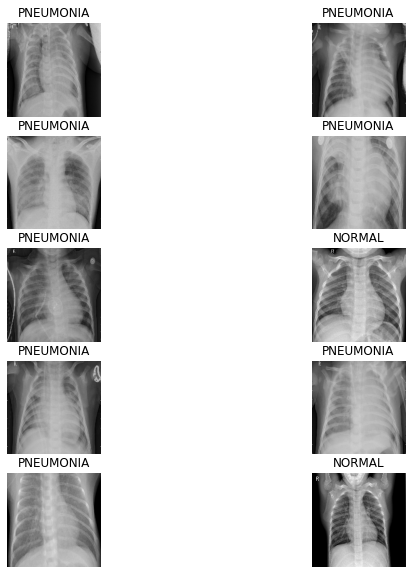

In [66]:
# train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_basic))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### 4-1 BatchNormalization & Dropout

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 4-2 BatchNormalizaition

In [20]:
def dense_block_B(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

### 4-3 Dropout

In [21]:
def dense_block_D(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 4. BatchNormalization & Dropout 제외

In [22]:
def dense_block_no(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
    ])
    
    return block

In [23]:
# 1. BatchNormalization & Dropout 둘 다 사용
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [24]:
# 2. BatchNormalization만 사용
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_B(512),
        dense_block_B(128),
        dense_block_B(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [25]:
# 3. Dropout만 사용
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_D(512, 0.7),
        dense_block_D(128, 0.5),
        dense_block_D(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [26]:
# 4. BatchNormalization & Dropout 둘 다 안 함
def build_model_4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_no(512),
        dense_block_no(128),
        dense_block_no(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

In [27]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 훈련

In [28]:
with tf.device('/GPU:0'):
    model = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
# '조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 함
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 117s 230ms/step - loss: 0.4128 - accuracy: 0.7967 - precision: 0.9488 - recall: 0.7682 - val_loss: 0.8460 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 96s 229ms/step - loss: 0.2757 - accuracy: 0.8878 - precision: 0.9671 - recall: 0.8791 - val_loss: 0.2574 - val_accuracy: 0.8760 - val_precision: 0.8555 - val_recall: 1.0000
Epoch 3/10
418/418 [==============================] - 97s 232ms/step - loss: 0.2303 - accuracy: 0.9057 - precision: 0.9771 - recall: 0.8941 - val_loss: 0.1200 - val_accuracy: 0.9558 - val_precision: 0.9787 - val_recall: 0.9607
Epoch 4/10
418/418 [==============================] - 99s 236ms/step - loss: 0.2292 - accuracy: 0.9112 - precision: 0.9744 - recall: 0.9045 - val_loss: 0.1225 - val_accuracy: 0.9587 - val_precision: 0.9918 - val_recall: 0.9516
Epoch 5/10
418/418 [==============================] - 104s 248ms/step - loss: 0.1933 - accu

In [31]:
with tf.device('/GPU:0'):
    model_aug = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS, 시간상 줄임 원래는 위에 25
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 146s 301ms/step - loss: 0.4555 - accuracy: 0.7682 - precision: 0.9328 - recall: 0.7416 - val_loss: 0.5716 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 119s 285ms/step - loss: 0.2873 - accuracy: 0.8818 - precision: 0.9655 - recall: 0.8724 - val_loss: 0.2453 - val_accuracy: 0.8971 - val_precision: 1.0000 - val_recall: 0.8603
Epoch 3/10
418/418 [==============================] - 119s 285ms/step - loss: 0.2690 - accuracy: 0.8888 - precision: 0.9665 - recall: 0.8811 - val_loss: 0.4960 - val_accuracy: 0.7875 - val_precision: 1.0000 - val_recall: 0.7111
Epoch 4/10
418/418 [==============================] - 119s 286ms/step - loss: 0.2461 - accuracy: 0.9017 - precision: 0.9690 - recall: 0.8963 - val_loss: 0.1634 - val_accuracy: 0.9394 - val_precision: 0.9986 - val_recall: 0.9187
Epoch 5/10
418/418 [==============================] - 116s 278ms/step - loss: 0.2106 - a

In [33]:
with tf.device('/GPU:0'):
    model_B = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_B.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [34]:
with tf.device('/GPU:0'):
    history_B = model_B.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 137s 274ms/step - loss: 0.3108 - accuracy: 0.8667 - precision: 0.9616 - recall: 0.8549 - val_loss: 0.9185 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 123s 295ms/step - loss: 0.1988 - accuracy: 0.9179 - precision: 0.9762 - recall: 0.9118 - val_loss: 0.4560 - val_accuracy: 0.7837 - val_precision: 0.7732 - val_recall: 1.0000
Epoch 3/10
418/418 [==============================] - 114s 273ms/step - loss: 0.1811 - accuracy: 0.9285 - precision: 0.9792 - recall: 0.9235 - val_loss: 0.2989 - val_accuracy: 0.8769 - val_precision: 0.8600 - val_recall: 0.9948
Epoch 4/10
418/418 [==============================] - 122s 292ms/step - loss: 0.1448 - accuracy: 0.9455 - precision: 0.9845 - recall: 0.9415 - val_loss: 0.3644 - val_accuracy: 0.8288 - val_precision: 0.8108 - val_recall: 1.0000
Epoch 5/10
418/418 [==============================] - 114s 272ms/step - loss: 0.1312 - a

In [35]:
with tf.device('/GPU:0'):
    model_D = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_D.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [36]:
with tf.device('/GPU:0'):
    history_D = model_D.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 138s 277ms/step - loss: 0.3700 - accuracy: 0.8263 - precision: 0.9385 - recall: 0.8202 - val_loss: 1.6699 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 83s 198ms/step - loss: 0.2136 - accuracy: 0.9213 - precision: 0.9806 - recall: 0.9122 - val_loss: 1.6508 - val_accuracy: 0.2663 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 3/10
418/418 [==============================] - 54s 129ms/step - loss: 0.1584 - accuracy: 0.9376 - precision: 0.9857 - recall: 0.9295 - val_loss: 0.0849 - val_accuracy: 0.9644 - val_precision: 0.9906 - val_recall: 0.9608
Epoch 4/10
418/418 [==============================] - 50s 119ms/step - loss: 0.1598 - accuracy: 0.9455 - precision: 0.9862 - recall: 0.9399 - val_loss: 0.2434 - val_accuracy: 0.8865 - val_precision: 0.9939 - val_recall: 0.8514
Epoch 5/10
418/418 [==============================] - 50s 120ms/step - loss: 0.1256 - accur

In [37]:
with tf.device('/GPU:0'):
    model_no = build_model_4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [38]:
with tf.device('/GPU:0'):
    history_no = model_no.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 58s 119ms/step - loss: 0.2545 - accuracy: 0.8801 - precision: 0.9725 - recall: 0.8633 - val_loss: 1.0578 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 50s 119ms/step - loss: 0.1342 - accuracy: 0.9435 - precision: 0.9858 - recall: 0.9376 - val_loss: 0.2179 - val_accuracy: 0.8981 - val_precision: 0.8784 - val_recall: 1.0000
Epoch 3/10
418/418 [==============================] - 49s 118ms/step - loss: 0.1465 - accuracy: 0.9371 - precision: 0.9847 - recall: 0.9299 - val_loss: 0.1247 - val_accuracy: 0.9596 - val_precision: 0.9959 - val_recall: 0.9490
Epoch 4/10
418/418 [==============================] - 49s 118ms/step - loss: 0.1123 - accuracy: 0.9526 - precision: 0.9902 - recall: 0.9457 - val_loss: 0.3173 - val_accuracy: 0.9115 - val_precision: 0.9971 - val_recall: 0.8825
Epoch 5/10
418/418 [==============================] - 50s 120ms/step - loss: 0.0949 - accura

In [39]:
with tf.device('/GPU:0'):
    model_no_aug = build_model_4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [40]:
with tf.device('/GPU:0'):
    history_no_aug = model_no_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 58s 119ms/step - loss: 0.2590 - accuracy: 0.8823 - precision: 0.9770 - recall: 0.8620 - val_loss: 1.9257 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 49s 118ms/step - loss: 0.1916 - accuracy: 0.9199 - precision: 0.9826 - recall: 0.9084 - val_loss: 0.1163 - val_accuracy: 0.9481 - val_precision: 0.9958 - val_recall: 0.9332
Epoch 3/10
418/418 [==============================] - 49s 116ms/step - loss: 0.1601 - accuracy: 0.9330 - precision: 0.9846 - recall: 0.9244 - val_loss: 0.4217 - val_accuracy: 0.8279 - val_precision: 0.9983 - val_recall: 0.7670
Epoch 4/10
418/418 [==============================] - 49s 118ms/step - loss: 0.1494 - accuracy: 0.9373 - precision: 0.9843 - recall: 0.9305 - val_loss: 0.2786 - val_accuracy: 0.8596 - val_precision: 0.8411 - val_recall: 0.9974
Epoch 00004: early stopping


In [41]:
with tf.device('/GPU:0'):
    model_B_aug = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_B_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [42]:
with tf.device('/GPU:0'):
    history_B_aug = model_B_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 59s 120ms/step - loss: 0.2937 - accuracy: 0.8708 - precision: 0.9669 - recall: 0.8555 - val_loss: 0.9138 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 49s 118ms/step - loss: 0.2101 - accuracy: 0.9156 - precision: 0.9762 - recall: 0.9087 - val_loss: 0.2056 - val_accuracy: 0.9067 - val_precision: 0.8911 - val_recall: 0.9948
Epoch 3/10
418/418 [==============================] - 50s 120ms/step - loss: 0.1869 - accuracy: 0.9249 - precision: 0.9778 - recall: 0.9199 - val_loss: 0.2748 - val_accuracy: 0.8837 - val_precision: 0.8658 - val_recall: 0.9961
Epoch 4/10
418/418 [==============================] - 50s 120ms/step - loss: 0.1732 - accuracy: 0.9301 - precision: 0.9789 - recall: 0.9260 - val_loss: 0.1056 - val_accuracy: 0.9587 - val_precision: 0.9905 - val_recall: 0.9530
Epoch 5/10
418/418 [==============================] - 50s 120ms/step - loss: 0.1567 - accura

In [43]:
with tf.device('/GPU:0'):
    model_D_aug = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_D_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
with tf.device('/GPU:0'):
    history_D_aug = model_D_aug.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/10
418/418 [==============================] - 59s 120ms/step - loss: 0.3645 - accuracy: 0.8230 - precision: 0.9551 - recall: 0.7996 - val_loss: 1.0696 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
418/418 [==============================] - 50s 119ms/step - loss: 0.2255 - accuracy: 0.9062 - precision: 0.9775 - recall: 0.8945 - val_loss: 0.1797 - val_accuracy: 0.9260 - val_precision: 0.9134 - val_recall: 0.9935
Epoch 3/10
418/418 [==============================] - 50s 119ms/step - loss: 0.2214 - accuracy: 0.9144 - precision: 0.9801 - recall: 0.9032 - val_loss: 0.3543 - val_accuracy: 0.8510 - val_precision: 1.0000 - val_recall: 0.7971
Epoch 4/10
418/418 [==============================] - 51s 121ms/step - loss: 0.1700 - accuracy: 0.9330 - precision: 0.9820 - recall: 0.9271 - val_loss: 0.2541 - val_accuracy: 0.8904 - val_precision: 0.8719 - val_recall: 0.9974
Epoch 00004: early stopping


# 7. 결과 확인
### 7-1 기존 모델

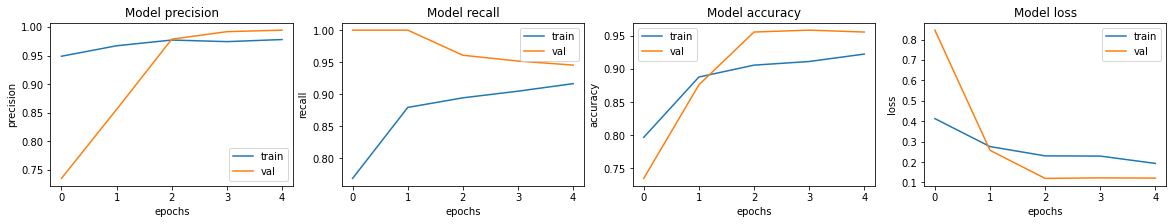

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-2 기존 모델 + augmentation

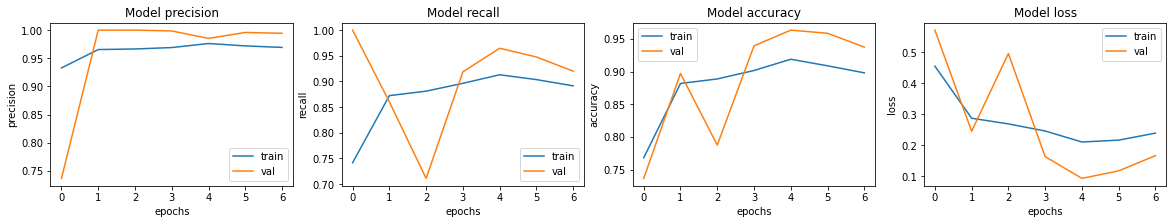

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-3 BatchNormalization

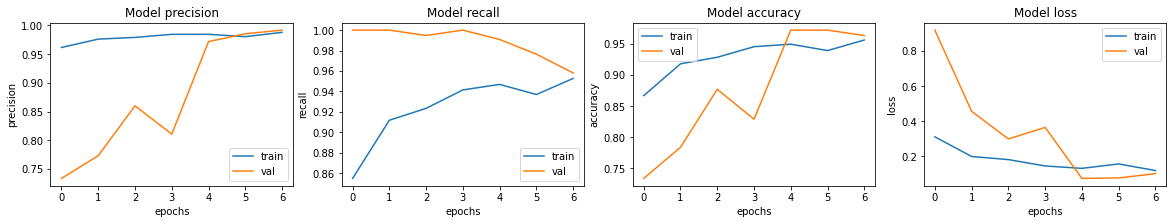

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_B.history[met])
    ax[i].plot(history_B.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-4 Dropout만

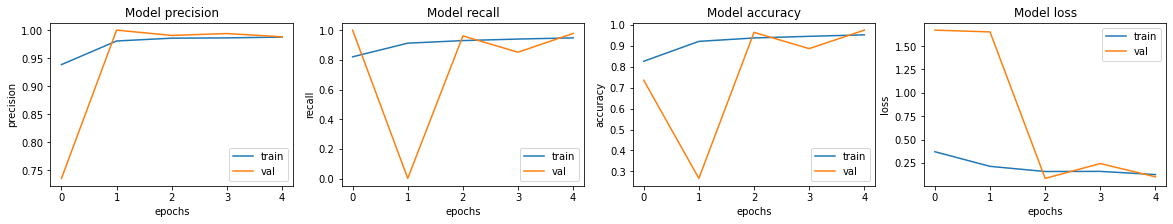

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_D.history[met])
    ax[i].plot(history_D.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-5 BatchNormalization & Dropout 제외

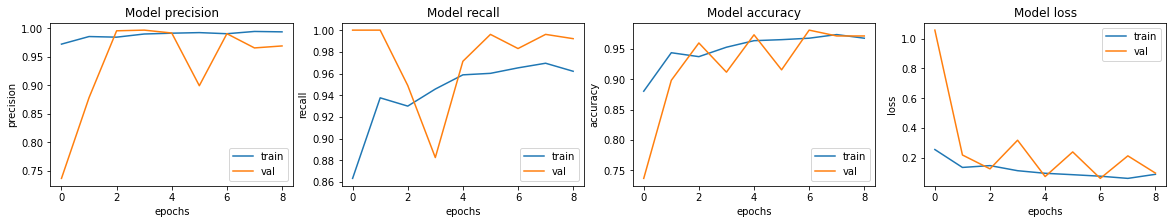

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no.history[met])
    ax[i].plot(history_no.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-6 BatchNormalization & Dropout 둘 다 없음 + augmentation

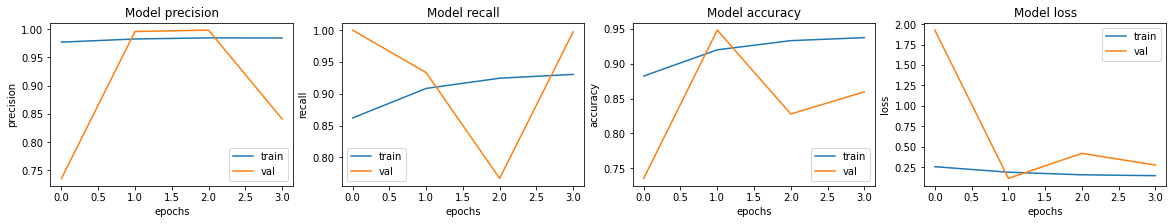

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug.history[met])
    ax[i].plot(history_no_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-7 BatchNormalization만 + augmentation

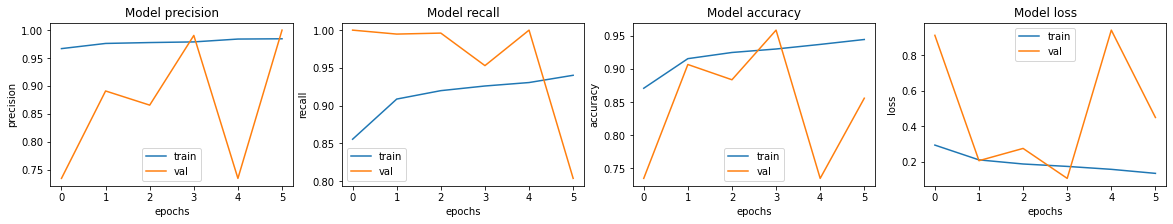

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_B_aug.history[met])
    ax[i].plot(history_B_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 7-8 Dropout만 + augmentation

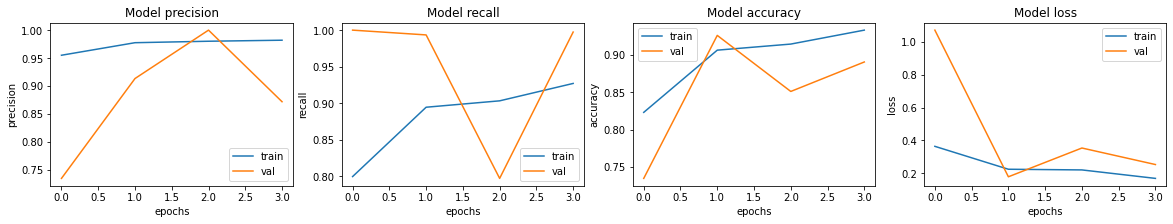

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_D_aug.history[met])
    ax[i].plot(history_D_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 기존 모델

In [53]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 5s 77ms/step - loss: 0.5112 - accuracy: 0.8093 - precision: 0.7782 - recall: 0.9718
Loss: 0.5111806392669678,
Accuracy: 0.8092948794364929,
Precision: 0.77823406457901,
Recall: 0.971794843673706


- 기존 모델 + augmentation

In [54]:
loss, accuracy, precision, recall = model_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 4s 66ms/step - loss: 0.5088 - accuracy: 0.7981 - precision: 0.7857 - recall: 0.9308
Loss: 0.5087665915489197,
Accuracy: 0.7980769276618958,
Precision: 0.7857142686843872,
Recall: 0.9307692050933838


- BatchNormalization만

In [55]:
loss, accuracy, precision, recall = model_B.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 4s 69ms/step - loss: 1.0730 - accuracy: 0.7708 - precision: 0.7370 - recall: 0.9846
Loss: 1.0729620456695557,
Accuracy: 0.7708333134651184,
Precision: 0.7370441555976868,
Recall: 0.9846153855323792


- Dropout만

In [56]:
loss, accuracy, precision, recall = model_D.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 4s 69ms/step - loss: 1.5239 - accuracy: 0.7804 - precision: 0.7456 - recall: 0.9846
Loss: 1.523911952972412,
Accuracy: 0.7804487347602844,
Precision: 0.7456310391426086,
Recall: 0.9846153855323792


- BatchNormalization & Dropout 둘 다 없음

In [57]:
loss, accuracy, precision, recall = model_no.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 4s 69ms/step - loss: 2.2892 - accuracy: 0.7228 - precision: 0.6941 - recall: 0.9949
Loss: 2.2892160415649414,
Accuracy: 0.7227563858032227,
Precision: 0.6940966248512268,
Recall: 0.9948717951774597


- BatchNormalization & Dropout 둘 다 없음 + augmentation

In [58]:
loss, accuracy, precision, recall = model_no_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 5s 72ms/step - loss: 1.4401 - accuracy: 0.6571 - precision: 0.6462 - recall: 0.9974
Loss: 1.4400708675384521,
Accuracy: 0.6570512652397156,
Precision: 0.6461793780326843,
Recall: 0.9974358677864075


- BatchNormalization만 + augmentation

In [59]:
loss, accuracy, precision, recall = model_B_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 4s 69ms/step - loss: 0.7065 - accuracy: 0.8157 - precision: 0.8395 - recall: 0.8718
Loss: 0.7064570784568787,
Accuracy: 0.8157051205635071,
Precision: 0.8395061492919922,
Recall: 0.8717948794364929


- Dropout만 + augmentation

In [60]:
loss, accuracy, precision, recall = model_D_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 5s 71ms/step - loss: 1.7358 - accuracy: 0.6715 - precision: 0.6555 - recall: 1.0000
Loss: 1.735834002494812,
Accuracy: 0.6714743375778198,
Precision: 0.6554622054100037,
Recall: 1.0


# 회고
은근 힘들었던 과제였다
준비 및 모델 구성할게 많았으며 많은 조건을 주어야 했기때문이다.
그래서 더더욱 이해도가 높을수 있었던 과제였다.

- 의료관련이기때문에 Recall값이 중요하고, 그에 따른 precision값을 효과적으로 올리는 방법이 있지 않을까?
- 분류성능평가지표에 대해 고려할 수 있는 좋은 과제였다.
- 학습이라는 관점에서 시도를 한건 좋았지만 이를 정리하고 중요하다고 느꼈음
- 캐글 설명을 읽어보면 X-ray 스캔은 특정 방향으로만 촬영되고 뒤집기 및 회전과 같은 변형은 실제 X-ray 이미지에 존재하지 않기 때문에 data augmentation는 모델에 포함하지 않는다고 했다.
- 주어진 기준에 맞추는것도 좋지만 더 좋은 결과를 뽑아내고 싶다